In [46]:
import sys
sys.path.append('/kaggle/input/bottleneck-package')
import bottleneck

import pandas as pd
import numpy as np
import os
import psutil  
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from pathlib import Path
import shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from functools import lru_cache
from pympler import asizeof

import typing
from dataclasses import dataclass
from collections.abc import Callable
from collections.abc import Sequence

import itertools

In [45]:
!pip install pympler

In [47]:
SUBMISSION = True
SUBMISSION = False
DEBUG = False
#DEBUG = True

VALIDATION_FRAC = 0.05
if SUBMISSION:
    DEBUG = False
    VALIDATION_FRAC = None
    
TRAIN_SIZE = 256 if DEBUG else None
SKIP_ASSERT = SUBMISSION or not DEBUG

In [48]:
USE_GPU = False
USE_TPU = False # = True not tested yet

In [49]:
ADAM_LEARNING_RATE = 0.0001

In [50]:
class DataUtils:
    @dataclass(frozen = True)
    class SubSequence(Sequence):
        source : Sequence
        start : int
        stop: int

        def __len__(self):
            return self.stop - self.start

        def __getitem__(self, index):
            if index < 0 or index >= self.stop - self.start:
                raise IndexError
            return self.source[self.start + index]  
        
    class BatchSlicer:
            def __init__(self, length: int, batch_size: int = None, num_batches: int = None):
                assert length >=0, 'invalid length, must be > 0'
                assert (batch_size is None) != (num_batches is None), \
                    'one and only one from batch_size and num_batches must be setted'
                assert batch_size is None or batch_size > 0, 'invalid batch_size, must be > 0'
                assert num_batches is None or num_batches > 0, 'invalid num_batches, must be > 0'
                self._length = length
                if num_batches is None:
                    self._batch_size = batch_size
                    self._num_batches = (self._length + self._batch_size - 1) // self._batch_size
                else:
                    self._num_batches = num_batches
                    self._batch_size = (self._length + self._num_batches - 1) // self._num_batches
                self._real_batch_size = self._length // self._num_batches
                self._num_full_batches = self._length - self._num_batches * self._real_batch_size 
                self._num_short_batches = self._num_batches - self._num_full_batches

            def __getitem__(self, index: int): # return -> range(begin, end)
                assert index>=0 and index < self._num_batches, \
                    'invalid batch index ={}, num_batches={}'.format(index, self._num_batches)
                if index < self._num_full_batches:
                    begin = index * (self._real_batch_size + 1)
                    end = begin + (self._real_batch_size + 1)
                else:
                    begin = self._num_full_batches * ( self._real_batch_size + 1) + \
                        (index - self._num_full_batches) * (self._real_batch_size)
                    end = begin + self._real_batch_size
                return range(begin, end)

            def __len__(self):
                return self._num_batches
            
    class BatchedSequence(Sequence):
        
        def __init__(self, source : Sequence, batch_size : int, item_dtype, item_shape):
            self.source = source
            self.item_dtype = item_dtype
            self.item_shape = item_shape
            self.batch_slicer = DataUtils.BatchSlicer(len(self.source), batch_size = batch_size)

        def __len__(self):
            return len(self.batch_slicer)

        def __getitem__(self, index):
            rng = self.batch_slicer[index]
            return np.fromiter(
                [
                      self.source[i] for i in rng
                ],
                count = rng.stop - rng.start, 
                dtype = (self.item_dtype, self.item_shape)
            )      
        
    @dataclass(frozen=True)
    class TransformSequence(Sequence):
        source : Sequence
        transform : Callable

        def __len__(self):
            return len(self.source)

        def __getitem__(self, index):
            return self.transform(self.source[index])     
        
    @dataclass(frozen = True)
    class JoinSequence(Sequence):
        a : Sequence
        b : Sequence

        def __len__(self):
            return len(self.a)

        def __getitem__(self, index):
            return (self.a[index], self.b[index])    
        
    @dataclass(frozen = True)
    class AsKerasSequence(keras.utils.Sequence):
        source : Sequence
        on_epoch_end_callback : Callable = lambda : True

        def __len__(self):
            return len(self.source)

        def __getitem__(self, index):
            return self.source[index]

        def on_epoch_end(self):
            self.on_epoch_end_callback()
            
    class SplitSubEpoches(keras.utils.Sequence):
        def __init__(self, source, num_sub_epoches):
            self.source = source
            self.num_sub_epoches = num_sub_epoches
            self.current_sub_epoch = 0
            self.slicer = DataUtils.BatchSlicer(len(self.source), num_batches = self.num_sub_epoches)

        def __len__(self):
            rng = self.slicer[self.current_sub_epoch]
            return rng.stop - rng.start

        def __getitem__(self, index):
            rng = self.slicer[self.current_sub_epoch]
            if index < 0 or index >= rng.stop - rng.start:
                raise IndexError()
            return self.source[rng.start + index]

        def on_epoch_end(self):
            self.current_sub_epoch += 1
            if self.current_sub_epoch == self.num_sub_epoches:
                self.source.on_epoch_end()
                self.current_sub_epoch = 0   
         
    @staticmethod        
    def scale_features(data):
        data = np.transpose(data, axes=(0,2,1))
        mean = np.nanmean(data, axis = (2), keepdims = True)
        std = np.nanstd(data, axis = (2), keepdims = True)
        std[std == 0] = 1
        data = np.nan_to_num((data - mean)/std, 0, 0, 0)
        data = np.transpose(data, axes=(0,2,1))
        return data   
    
    @staticmethod
    def decrease_int_type(column):
        try:
            new_column = column.astype('int8')
            if new_column.astype(column.dtype).equals(column):
                return new_column
        except Exception:
            pass
        try:
            new_column = column.astype('int16')
            if new_column.astype(column.dtype).equals(column):
                return new_column
        except Exception:
            pass
        try:
            new_column = column.astype('int32')
            if new_column.astype(column.dtype).equals(column):
                return new_column
        except Exception:
            pass
        return column  

In [51]:
class EEG:
    #TRAIN_PATH = '/content/drive/MyDrive/kaggle_dataset/train_eegs'
    #TEST_PATH = '/content/drive/MyDrive/kaggle_dataset/test_eegs'
    
    TRAIN_PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs'
    TEST_PATH =  '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs'
    
    FRAME_PER_SECOND = 200
    FRAME = 50 * FRAME_PER_SECOND
    
    FILTER_PERIOD = 7
    FILTER_BASE_PERIOD = FILTER_PERIOD * 41

    WINDOW_IN_SEC = 24 # in seconds
    WINDOW = WINDOW_IN_SEC * FRAME_PER_SECOND # in ticks
    MODEL_WINDOW = WINDOW // 3    
    
    COLUMNS =  [ # to assert columns order is the same
        'Fp1','F3', 'C3', 'P3', 'F7', 
        'T3', 'T5', 'O1', 'Fz', 'Cz', 
        'Pz', 'Fp2', 'F4', 'C4', 'P4',
        'F8', 'T4', 'T6', 'O2', 'EKG'
    ]    
    
    FEATURES = COLUMNS
    
    @staticmethod
    def load_train_frame(id):
        data = pd.read_parquet(
            os.path.join(EEG.TRAIN_PATH, str(id) + '.parquet'), 
            engine='pyarrow'
        )
        if not SKIP_ASSERT:
            assert list(data.columns) == EEG.COLUMNS, 'EEG columns order is not the same!'
        return data

    @staticmethod
    def load_test_frame(id):
        data = pd.read_parquet(
            os.path.join(EEG.TEST_PATH, str(id) + '.parquet'), 
            engine='pyarrow'
        )
        if not SKIP_ASSERT:
            assert list(data.columns) == EEG.COLUMNS, 'EEG columns order is not the same!'
        return data
    
    @staticmethod
    def filter_signals(data): # shape = time_index, eeg_chanal
        data = data[
            len(data)//2 - EEG.WINDOW//2 - EEG.FILTER_BASE_PERIOD : 
            len(data)//2 + EEG.WINDOW//2 + EEG.FILTER_BASE_PERIOD
        ]
        data = np.nan_to_num(data, nan = 0, copy = False)
        base_mean = bottleneck.move_mean(
            data, window=EEG.FILTER_BASE_PERIOD, 
            min_count=1, axis = 0
        )
        data = data - base_mean
        data = bottleneck.move_mean(data, window=EEG.FILTER_PERIOD, min_count=1, axis = 0)
        total_max = np.max(np.abs(data), axis = 0)
        data = data[::EEG.WINDOW // EEG.MODEL_WINDOW]
        total_max = total_max.reshape(1,20)
        total_max[total_max == 0] = 1
        data = data[len(data)//2 - EEG.MODEL_WINDOW//2 : len(data)//2 + EEG.MODEL_WINDOW//2]
        data = data / total_max
        return data    
    
    
    class TrainLoader(Callable):
        def __init__(self, train_info):
            self.data = pd.DataFrame(
                {
                    c : DataUtils.decrease_int_type(train_info[c]) 
                    for c in ['eeg_id','eeg_label_offset_seconds']
                }
            )

        @lru_cache(maxsize = None)
        def __call__(self, index):
            eeg_id, start = self.data.iloc[index] 
            start = start * EEG.FRAME_PER_SECOND
            end = start + EEG.FRAME
            data = EEG.load_train_frame(eeg_id)
            if not SKIP_ASSERT:
                assert start >=0 and start <= len(data), 'inlvalid start = {}, len = {}'.format(start, len(data))
                assert end <= len(data) and end >=0, 'invalid end = {}, len = {}'.format(end, len(data))
            data = EEG.filter_signals(data[EEG.FEATURES].iloc[start:end].to_numpy())
            return data.astype(dtype = np.float32)
    

    class TestLoader(Callable):
        def __init__(self, test_info):
            self.data = test_info

        def __call__(self, index):
            eeg_id = self.data['eeg_id'].iloc[index]
            data = EEG.load_test_frame(eeg_id)
            return EEG.filter_signals(data.to_numpy())
        
    @staticmethod
    def create_model_input(ids,loader, batch_size):
        eeg = DataUtils.TransformSequence(ids, loader)
        eeg = DataUtils.BatchedSequence(
            eeg, batch_size,
            item_dtype = np.float32, 
            item_shape = (EEG.MODEL_WINDOW, len(EEG.FEATURES))
        )
        return eeg

In [52]:
class Data:
    TEST_PATH = '/kaggle/input/hms-harmful-brain-activity-classification/test.csv'
    TRAIN_PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train.csv'


    @staticmethod
    def load_train_info(num_samples = None):
        train_info = (
            pd.read_csv(Data.TRAIN_PATH)
            .drop(columns = [
                'expert_consensus',
                'eeg_sub_id',
                'spectrogram_sub_id',
                'patient_id',
                'label_id'
            ])
        )
        if not num_samples is None:
            train_info = train_info.sample(num_samples)
        return train_info

    @staticmethod
    def load_train(num_samples = None):
        train_info = Data.load_train_info(num_samples)
        return (
            len(train_info),
            EEG.TrainLoader(train_info), 
            SPECTR.TrainLoader(train_info),
            Target.TrainLoader(train_info)
        )

    @staticmethod
    def load_test():
        test_info = pd.read_csv(Data.TEST_PATH)
        return (
            len(test_info), 
            EEG.TestLoader(test_info), 
            SPECTR.TestLoader(test_info), 
            EEG_ID.TestLoader(test_info)
        )

In [53]:
class EEG_ID:
    class TestLoader(Callable):
        def __init__(self, test_info):
            self.data = test_info

        def __call__(self, index):
            eeg_id = self.data['eeg_id'].iloc[index]
            return eeg_id

    @staticmethod
    def create_model_data(ids, loader, batch_size):
        eeg_id = DataUtils.TransformSequence(ids, loader)
        eeg_id = DataUtils.BatchedSequence(
            eeg_id, batch_size,
            item_dtype = np.int64,
            item_shape = (1,)
        )
        return eeg_id

In [54]:
class SPECTR:
    TRAIN_PATH =  '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms'
    TEST_PATH = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms'

    FRAME = 10 * 60 // 2

    NUM_FEATURES = 4
    NUM_CHANALS = 100
    MODEL_WINDOW = 99

    COLUMNS = [ # to assert columns order is the same
        'time',
        'LL_0.59', 'LL_0.78', 'LL_0.98', 'LL_1.17', 'LL_1.37',
        'LL_1.56', 'LL_1.76', 'LL_1.95', 'LL_2.15', 'LL_2.34',
        'LL_2.54', 'LL_2.73', 'LL_2.93', 'LL_3.13', 'LL_3.32',
        'LL_3.52', 'LL_3.71', 'LL_3.91', 'LL_4.1', 'LL_4.3',
        'LL_4.49', 'LL_4.69', 'LL_4.88', 'LL_5.08', 'LL_5.27',
        'LL_5.47', 'LL_5.66', 'LL_5.86', 'LL_6.05', 'LL_6.25',
        'LL_6.45', 'LL_6.64', 'LL_6.84', 'LL_7.03', 'LL_7.23',
        'LL_7.42', 'LL_7.62', 'LL_7.81', 'LL_8.01', 'LL_8.2',
        'LL_8.4', 'LL_8.59', 'LL_8.79', 'LL_8.98', 'LL_9.18',
        'LL_9.38', 'LL_9.57', 'LL_9.77', 'LL_9.96', 'LL_10.16',
        'LL_10.35', 'LL_10.55', 'LL_10.74', 'LL_10.94', 'LL_11.13',
        'LL_11.33', 'LL_11.52', 'LL_11.72', 'LL_11.91', 'LL_12.11',
        'LL_12.3', 'LL_12.5', 'LL_12.7', 'LL_12.89', 'LL_13.09',
        'LL_13.28', 'LL_13.48', 'LL_13.67', 'LL_13.87', 'LL_14.06',
        'LL_14.26', 'LL_14.45', 'LL_14.65', 'LL_14.84', 'LL_15.04',
        'LL_15.23', 'LL_15.43', 'LL_15.63', 'LL_15.82', 'LL_16.02',
        'LL_16.21', 'LL_16.41', 'LL_16.6', 'LL_16.8', 'LL_16.99',
        'LL_17.19', 'LL_17.38', 'LL_17.58', 'LL_17.77', 'LL_17.97',
        'LL_18.16', 'LL_18.36', 'LL_18.55', 'LL_18.75', 'LL_18.95',
        'LL_19.14', 'LL_19.34', 'LL_19.53', 'LL_19.73', 'LL_19.92',
        'RL_0.59', 'RL_0.78', 'RL_0.98', 'RL_1.17', 'RL_1.37',
        'RL_1.56', 'RL_1.76', 'RL_1.95', 'RL_2.15', 'RL_2.34',
        'RL_2.54', 'RL_2.73', 'RL_2.93', 'RL_3.13', 'RL_3.32',
        'RL_3.52', 'RL_3.71', 'RL_3.91', 'RL_4.1', 'RL_4.3',
        'RL_4.49', 'RL_4.69', 'RL_4.88', 'RL_5.08', 'RL_5.27',
        'RL_5.47', 'RL_5.66', 'RL_5.86', 'RL_6.05', 'RL_6.25',
        'RL_6.45', 'RL_6.64', 'RL_6.84', 'RL_7.03', 'RL_7.23',
        'RL_7.42', 'RL_7.62', 'RL_7.81', 'RL_8.01', 'RL_8.2',
        'RL_8.4', 'RL_8.59', 'RL_8.79', 'RL_8.98', 'RL_9.18',
        'RL_9.38', 'RL_9.57', 'RL_9.77', 'RL_9.96', 'RL_10.16',
        'RL_10.35', 'RL_10.55', 'RL_10.74', 'RL_10.94', 'RL_11.13',
        'RL_11.33', 'RL_11.52', 'RL_11.72', 'RL_11.91', 'RL_12.11',
        'RL_12.3', 'RL_12.5', 'RL_12.7', 'RL_12.89', 'RL_13.09',
        'RL_13.28', 'RL_13.48', 'RL_13.67', 'RL_13.87', 'RL_14.06',
        'RL_14.26', 'RL_14.45', 'RL_14.65', 'RL_14.84', 'RL_15.04',
        'RL_15.23', 'RL_15.43', 'RL_15.63', 'RL_15.82', 'RL_16.02',
        'RL_16.21', 'RL_16.41', 'RL_16.6', 'RL_16.8', 'RL_16.99',
        'RL_17.19', 'RL_17.38', 'RL_17.58', 'RL_17.77', 'RL_17.97',
        'RL_18.16', 'RL_18.36', 'RL_18.55', 'RL_18.75', 'RL_18.95',
        'RL_19.14', 'RL_19.34', 'RL_19.53', 'RL_19.73', 'RL_19.92',
        'LP_0.59', 'LP_0.78', 'LP_0.98', 'LP_1.17', 'LP_1.37',
        'LP_1.56', 'LP_1.76', 'LP_1.95', 'LP_2.15', 'LP_2.34',
        'LP_2.54', 'LP_2.73', 'LP_2.93', 'LP_3.13', 'LP_3.32',
        'LP_3.52', 'LP_3.71', 'LP_3.91', 'LP_4.1', 'LP_4.3',
        'LP_4.49', 'LP_4.69', 'LP_4.88', 'LP_5.08', 'LP_5.27',
        'LP_5.47', 'LP_5.66', 'LP_5.86', 'LP_6.05', 'LP_6.25',
        'LP_6.45', 'LP_6.64', 'LP_6.84', 'LP_7.03', 'LP_7.23',
        'LP_7.42', 'LP_7.62', 'LP_7.81', 'LP_8.01', 'LP_8.2',
        'LP_8.4', 'LP_8.59', 'LP_8.79', 'LP_8.98', 'LP_9.18',
        'LP_9.38', 'LP_9.57', 'LP_9.77', 'LP_9.96', 'LP_10.16',
        'LP_10.35', 'LP_10.55', 'LP_10.74', 'LP_10.94', 'LP_11.13',
        'LP_11.33', 'LP_11.52', 'LP_11.72', 'LP_11.91', 'LP_12.11',
        'LP_12.3', 'LP_12.5', 'LP_12.7', 'LP_12.89', 'LP_13.09',
        'LP_13.28', 'LP_13.48', 'LP_13.67', 'LP_13.87', 'LP_14.06',
        'LP_14.26', 'LP_14.45', 'LP_14.65', 'LP_14.84', 'LP_15.04',
        'LP_15.23', 'LP_15.43', 'LP_15.63', 'LP_15.82', 'LP_16.02',
        'LP_16.21', 'LP_16.41', 'LP_16.6', 'LP_16.8', 'LP_16.99',
        'LP_17.19', 'LP_17.38', 'LP_17.58', 'LP_17.77', 'LP_17.97',
        'LP_18.16', 'LP_18.36', 'LP_18.55', 'LP_18.75', 'LP_18.95',
        'LP_19.14', 'LP_19.34', 'LP_19.53', 'LP_19.73', 'LP_19.92',
        'RP_0.59', 'RP_0.78', 'RP_0.98', 'RP_1.17', 'RP_1.37',
        'RP_1.56', 'RP_1.76', 'RP_1.95', 'RP_2.15', 'RP_2.34',
        'RP_2.54', 'RP_2.73', 'RP_2.93', 'RP_3.13', 'RP_3.32',
        'RP_3.52', 'RP_3.71', 'RP_3.91', 'RP_4.1', 'RP_4.3',
        'RP_4.49', 'RP_4.69', 'RP_4.88', 'RP_5.08', 'RP_5.27',
        'RP_5.47', 'RP_5.66', 'RP_5.86', 'RP_6.05', 'RP_6.25',
        'RP_6.45', 'RP_6.64', 'RP_6.84', 'RP_7.03', 'RP_7.23',
        'RP_7.42', 'RP_7.62', 'RP_7.81', 'RP_8.01', 'RP_8.2',
        'RP_8.4', 'RP_8.59', 'RP_8.79', 'RP_8.98', 'RP_9.18',
        'RP_9.38', 'RP_9.57', 'RP_9.77', 'RP_9.96', 'RP_10.16',
        'RP_10.35', 'RP_10.55', 'RP_10.74', 'RP_10.94', 'RP_11.13',
        'RP_11.33', 'RP_11.52', 'RP_11.72', 'RP_11.91', 'RP_12.11',
        'RP_12.3', 'RP_12.5', 'RP_12.7', 'RP_12.89', 'RP_13.09',
        'RP_13.28', 'RP_13.48', 'RP_13.67', 'RP_13.87', 'RP_14.06',
        'RP_14.26', 'RP_14.45', 'RP_14.65', 'RP_14.84', 'RP_15.04',
        'RP_15.23', 'RP_15.43', 'RP_15.63', 'RP_15.82', 'RP_16.02',
        'RP_16.21', 'RP_16.41', 'RP_16.6', 'RP_16.8', 'RP_16.99',
        'RP_17.19', 'RP_17.38', 'RP_17.58', 'RP_17.77', 'RP_17.97',
        'RP_18.16', 'RP_18.36', 'RP_18.55', 'RP_18.75', 'RP_18.95',
        'RP_19.14', 'RP_19.34', 'RP_19.53', 'RP_19.73', 'RP_19.92'
    ]

    FEATURES = list([x for x in COLUMNS if x != 'time'])

    @staticmethod
    def load_train_frame(id):
        data = pd.read_parquet(
            os.path.join(SPECTR.TRAIN_PATH, str(id) + '.parquet'),
            engine='pyarrow'
        )
        if not SKIP_ASSERT:
            assert all([(data['time'].iloc[i] == (2*i + 1)) for i in range(len(data))]), 'time inconsistent'
            assert list(data.columns) == SPECTR.COLUMNS, 'SPECTR columns order is not the same!'
        return data.drop(columns = 'time')

    @staticmethod
    def load_test_frame(id):
        data = pd.read_parquet(
            os.path.join(SPECTR.TEST_PATH, str(id) + '.parquet'),
            engine='pyarrow'
        )
        if not SKIP_ASSERT:
            assert list(data.columns) == SPECTR.COLUMNS, 'SPECTR columns order is not the same!'
        return data.drop(columns = 'time')

    class TrainLoader(Callable):
        def __init__(self, train_info):
            self.data = pd.DataFrame(
                {
                    c : DataUtils.decrease_int_type(train_info[c])
                    for c in ['spectrogram_id','spectrogram_label_offset_seconds']
                }
            )

        def __call__(self, index):
            spectr_id, start = self.data.iloc[index]
            start = start // 2
            end = start + SPECTR.FRAME
            data = SPECTR.load_train_frame(spectr_id)
            if not SKIP_ASSERT:
                assert start >=0 and start <= len(data), 'inlvalid start = {}, len = {}'.format(start, len(data))
                assert end <= len(data) and end >=0, 'invalid end = {}, len = {}'.format(end, len(data))
            return data[SPECTR.FEATURES].iloc[start:end].to_numpy()

    class TestLoader(Callable):
        def __init__(self, test_info):
            self.data = test_info

        def __call__(self, index):
            id = self.data['spectrogram_id'].iloc[index]
            return SPECTR.load_test_frame(id).to_numpy()

    @staticmethod
    def reshape_spectr_data(data):
        data = np.nan_to_num(data)
        data = bottleneck.move_max(data, 5, min_count = 1, axis = 0)
        maxdata = np.max(data, axis = 0, keepdims = True)
        maxdata[maxdata == 0] = 1
        data = data[5::3] / maxdata
        return np.reshape(data, newshape = (len(data), SPECTR.NUM_FEATURES, SPECTR.NUM_CHANALS))

    @staticmethod
    def create_model_input(ids, loader, batch_size):
        spectr = DataUtils.TransformSequence(ids, loader)
        spectr = DataUtils.TransformSequence(spectr, SPECTR.reshape_spectr_data)
        spectr = DataUtils.BatchedSequence(
            spectr, batch_size,
            item_dtype = np.float64,
            item_shape = (SPECTR.MODEL_WINDOW, SPECTR.NUM_FEATURES, SPECTR.NUM_CHANALS)
        )
        return spectr

In [55]:
class Target:
    COLUMNS = [
        'seizure_vote',
        'lpd_vote',
        'gpd_vote',
        'lrda_vote',
        'grda_vote',
        'other_vote'
    ]

    FEATURES = COLUMNS

    @staticmethod
    def scale_probs(probs):
        s = np.sum(probs, axis = -1, keepdims = True)
        return probs/s

    class TrainLoader(Callable):
        def __init__(self, train_info):
            self.data = Target.scale_probs(train_info[Target.FEATURES].to_numpy())

        def __call__(self, index):
            return self.data[index]

    @staticmethod
    def create_model_data(ids, target_loader, batch_size):
        targets = DataUtils.TransformSequence(ids, target_loader)
        targets = DataUtils.BatchedSequence(
            targets, BATCH_SIZE,
            item_dtype = np.float64,
            item_shape = (len(Target.FEATURES),)
        )
        return targets

    @staticmethod
    def make_decision(probs):
        decision = np.zeros_like(probs)
        decision[np.arange(len(probs)), probs.argmax(1)] = 1
        return decision

In [56]:
%run -i '/kaggle/input/hms-share/data-utils.py'
%run -i '/kaggle/input/hms-share/eeg.py'
%run -i '/kaggle/input/hms-share/spectr.py'
%run -i '/kaggle/input/hms-share/target.py'
%run -i '/kaggle/input/hms-share/eeg_id.py'
%run -i '/kaggle/input/hms-share/data.py'

<Figure size 640x480 with 0 Axes>

In [57]:
NUM_EPOCHS = 30
NUM_SUB_EPOCHS = 5 if not DEBUG else 2
BATCH_SIZE = 128

In [60]:
print('SUBMISSION =', SUBMISSION)
print('USE_TPU =', USE_TPU)
print('USE_GPU =', USE_GPU)
print('DEBUG = ', DEBUG)

SUBMISSION = False
USE_TPU = False
USE_GPU = False
DEBUG =  False


In [61]:
def size_2_str(value):
    if value < 5 * 1024:
        return str(value) + ' bytes'
    if value < 5 * 1024 * 1024:
        return str(value//1024) + ' KB'
    return str(value//(1024*1024)) +' MB'

def get_mem_usage():
    pid = os.getpid()
    py = psutil.Process(pid)
    return py.memory_info()[0] // 2 ** 20

In [62]:
def scale_probs(probs):
    s = np.sum(probs, axis = -1, keepdims = True)
    return probs/s

In [63]:
def assert_no_nan(x):
    assert not np.isnan(x).any(), 'has NAN!!!'
    return x

In [64]:
def scale_features(data):
    data = np.transpose(data, axes=(0,2,1))
    mean = np.nanmean(data, axis = (2), keepdims = True)
    std = np.nanstd(data, axis = (2), keepdims = True)
    std[std == 0] = 1
    data = np.nan_to_num((data - mean)/std, 0, 0, 0)
    data = np.transpose(data, axes=(0,2,1))
    return data

In [65]:
def create_eeg_model():
    input = keras.layers.Input(
        shape = (EEG.MODEL_WINDOW, len(EEG.FEATURES)), name = 'eeg.input'
    )
    model = keras.layers.Conv1D(
        filters = 27, kernel_size = 11, padding = 'valid', strides = 3,
        name = 'eeg.1', data_format="channels_last", 
        activation = 'relu'
    )(input)
    #model = keras.layers.Dropout(rate = 0.05, name = 'eeg.1.dropout')(model)
    model = keras.layers.MaxPooling1D(
        pool_size = 7, strides = 3, name = 'eeg.1.max'
    )(model)
    model = keras.layers.Conv1D(
        filters = 31, kernel_size = 11, padding = 'valid', strides = 3,
        name = 'eeg.2', data_format="channels_last", 
        activation = 'relu'
    )(model)
    #model = keras.layers.Dropout(rate = 0.05, name = 'eeg.2.dropout')(model)
    model = keras.layers.MaxPooling1D(
        pool_size = 5, strides = 3, name = 'eeg.2.max'
    )(model)
    model = keras.layers.Conv1D(
        filters = 37, kernel_size = 7, padding = 'valid', name = 'eeg.3', strides = 2,
        activation = 'relu'
    )(model)
    #model = keras.layers.Dropout(rate = 0.05, name = 'eeg.3.dropout')(model)
    model = keras.layers.MaxPooling1D(
        pool_size = 6, strides = 1, name = 'eeg.3.max'
    )(model)
#    model = keras.layers.Conv1D(
#        filters = 41, kernel_size = 11, padding = 'valid', name = 'eeg.4', strides = 2,
#        activation = 'relu'
#    )(model)
#    model = keras.layers.MaxPooling1D(
#        pool_size = 7, strides = 2, name = 'eeg.4.max'
#    )(model)
    model = keras.layers.Flatten(name = 'eeg.flatten')(model)
    model = keras.layers.Dense(
        units = 11, activation='relu', name = 'eeg.dense.1', 
    )(model)
    model = keras.layers.Dense(
        units = 11, activation='relu', name = 'eeg.dense.2', 
    )(model)
    model = keras.layers.Dense(
        units = len(Target.FEATURES), activation='softmax',name = 'eeg.output'
    )(model)
    model = keras.models.Model(inputs=input, outputs=model)
    return model    

In [66]:
if USE_TPU:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [67]:
def create_and_compile_model():
    model = create_eeg_model()
    optimizer = Adam(learning_rate = ADAM_LEARNING_RATE)
    model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['acc'])
    return model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eeg.input (InputLayer)      [(None, 1600, 20)]        0         
                                                                 
 eeg.1 (Conv1D)              (None, 530, 27)           5967      
                                                                 
 eeg.1.max (MaxPooling1D)    (None, 175, 27)           0         
                                                                 
 eeg.2 (Conv1D)              (None, 55, 31)            9238      
                                                                 
 eeg.2.max (MaxPooling1D)    (None, 17, 31)            0         
                                                                 
 eeg.3 (Conv1D)              (None, 6, 37)             8066      
                                                                 
 eeg.3.max (MaxPooling1D)    (None, 1, 37)             0   

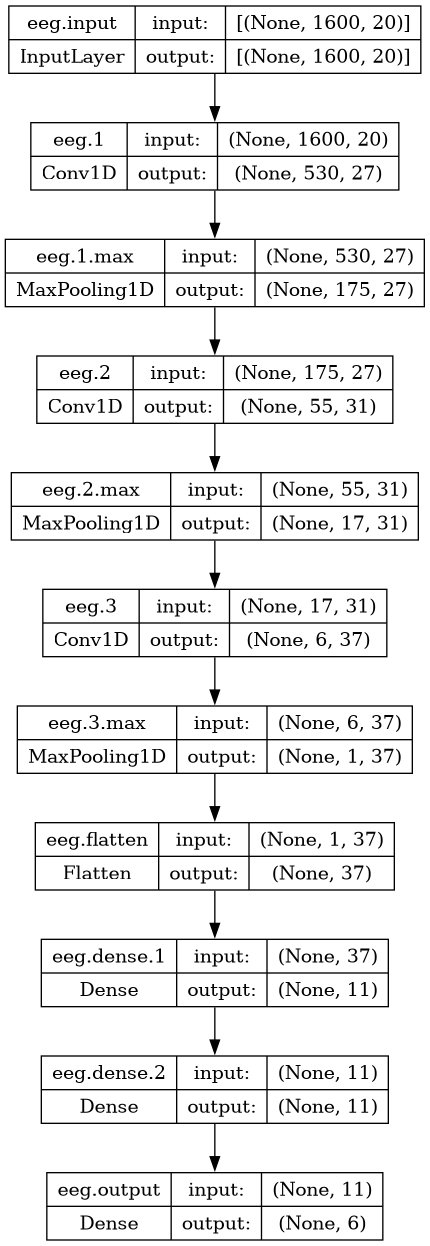

In [68]:
if USE_TPU:
    with tpu_strategy.scope():
        model = create_and_compile_model()

else:
    model = create_and_compile_model()
    
model.summary()
keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [69]:
def build_train_data(
    ids, 
    eeg_loader, 
    target_loader
):
    eeg = EEG.create_model_input(ids, eeg_loader, BATCH_SIZE)
    target = Target.create_model_data(ids, target_loader, BATCH_SIZE)
    
    eeg_target = DataUtils.JoinSequence(eeg, target)
    return DataUtils.AsKerasSequence(eeg_target, lambda : random.shuffle(ids))
    

In [ ]:
train_size, train_eeg_loader, _, train_target_loader \
    = Data.load_train(TRAIN_SIZE)
train_ids = list([x for x in range(train_size)])
if VALIDATION_FRAC > 0:
    train_ids, valid_ids = train_test_split(train_ids, test_size = VALIDATION_FRAC)
    
train_data = build_train_data(train_ids, train_eeg_loader, train_target_loader)
if VALIDATION_FRAC > 0:
    valid_data = build_train_data(valid_ids, train_eeg_loader, train_target_loader) 
else:
    valid_data = None    
train_data = DataUtils.SplitSubEpoches(train_data, NUM_SUB_EPOCHS)

In [30]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [31]:
%%time

def fit_model(model, train_data, epochs, validation_data):
    if USE_GPU:
        with tf.device('/gpu:0'):
            return model.fit(
                train_data, 
                epochs = epochs, 
                validation_data = validation_data)
    else:
        return model.fit(
            train_data, 
            epochs = epochs, 
            validation_data = validation_data)
        
history = fit_model(
    model,
    train_data, 
    NUM_EPOCHS * NUM_SUB_EPOCHS, 
    valid_data
)

Epoch 1/150


I0000 00:00:1716227859.328966      99 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


159/159 [==============================] - 531s 3s/step - loss: 1.7534 - acc: 0.1995 - val_loss: 1.7245 - val_acc: 0.2079
Epoch 2/150
159/159 [==============================] - 308s 2s/step - loss: 1.6884 - acc: 0.2650 - val_loss: 1.6422 - val_acc: 0.3039
Epoch 3/150
159/159 [==============================] - 326s 2s/step - loss: 1.6019 - acc: 0.3517 - val_loss: 1.5628 - val_acc: 0.3824
Epoch 4/150
159/159 [==============================] - 355s 2s/step - loss: 1.5364 - acc: 0.3938 - val_loss: 1.5044 - val_acc: 0.4116
Epoch 5/150
159/159 [==============================] - 323s 2s/step - loss: 1.4850 - acc: 0.4200 - val_loss: 1.4592 - val_acc: 0.4391
Epoch 6/150
159/159 [==============================] - 2s 15ms/step - loss: 1.4411 - acc: 0.4468 - val_loss: 1.4258 - val_acc: 0.4509
Epoch 7/150
159/159 [==============================] - 2s 16ms/step - loss: 1.4091 - acc: 0.4724 - val_loss: 1.3946 - val_acc: 0.4747
Epoch 8/150
159/159 [==============================] - 3s 16ms/step - loss

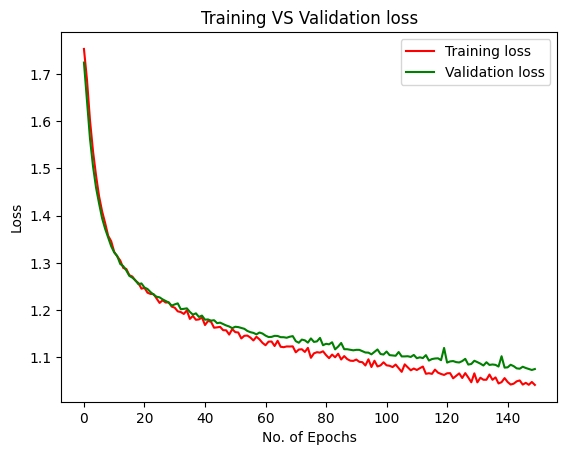

In [32]:
plt.plot(history.history['loss'], 'r', label='Training loss')
if VALIDATION_FRAC > 0:
    plt.plot(history.history['val_loss'], 'g', label='Validation loss')
plt.title('Training VS Validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

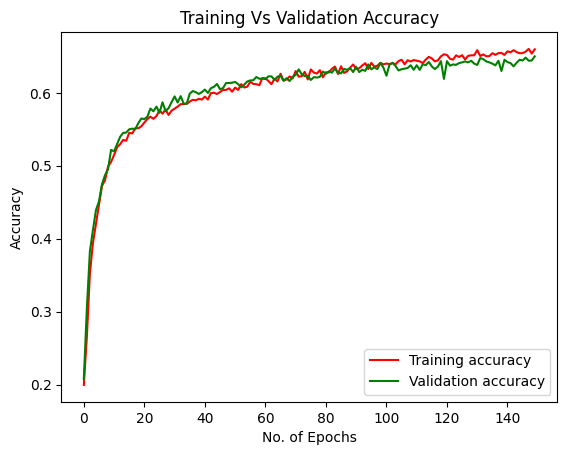

In [33]:
plt.plot(history.history['acc'], 'r', label='Training accuracy')
if VALIDATION_FRAC > 0:
    plt.plot(history.history['val_acc'], 'g', label='Validation accuracy')
plt.title('Training Vs Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
print('--------------- model fitted ----------------------')

--------------- model fitted ----------------------


In [36]:
def check_validation():
    y_true = []
    y_predict = []
    for index in range(len(valid_data)):
        train_batch, target_batch = valid_data[index]
        predict = model.predict(train_batch)
        decision = Target.make_decision(predict)
        target_decision = Target.make_decision(target_batch)
        for i in range(len(decision)):
            y_predict.append(decision[i])
            y_true.append(target_decision[i])
    print('accuracy =', accuracy_score(y_true, y_predict))

In [37]:
%%time

if VALIDATION_FRAC > 0:
    if USE_GPU:
        with tf.device('/gpu:0'):
            check_validation()
    else:
        check_validation()

4/4 [==============================] - 0s 3ms/step
accuracy = 0.65
CPU times: user 4.43 s, sys: 564 ms, total: 4.99 s
Wall time: 4.83 s


In [38]:
print('mem usage =', size_2_str(get_mem_usage()))
del train_eeg_loader,train_target_loader

mem usage = 15 KB


In [39]:
def build_test_data(ids, eeg_loader, eeg_id_loader):
    eeg = EEG.create_model_input(ids, eeg_loader, BATCH_SIZE)
    eeg_id = EEG_ID.create_model_data(ids, eeg_id_loader, BATCH_SIZE)
    
    eeg_eeg_id_seq = DataUtils.JoinSequence(eeg, eeg_id)
    return DataUtils.AsKerasSequence(eeg_eeg_id_seq)

In [40]:
test_size, test_eeg_loader, _, test_eeg_id_loader = Data.load_test()
test_data = build_test_data(
    list([x for x in range(test_size)]), 
    test_eeg_loader, 
    test_eeg_id_loader
)

In [41]:
%%time

output = []
for index in range(len(test_data)):
    batch, eeg_ids = test_data[index]
    predict = model.predict(batch)
    for i in range(len(eeg_ids)):
        res = [*eeg_ids[i]]
        res.extend(predict[i].tolist())
        output.append(res)
output = pd.DataFrame(
    data = output,
    columns = ['eeg_id'] + Target.FEATURES
)
output.to_csv('submission.csv', index = False)


1/1 [==============================] - 0s 103ms/step
CPU times: user 133 ms, sys: 10.7 ms, total: 143 ms
Wall time: 183 ms


In [42]:
model.save('eeg_model.keras')

In [43]:
print('--------------- submission done ----------------------')

--------------- submission done ----------------------
